## Accessing ICESat-2 Data
### Software Development Notebook
This notebook outlines and begins development for functionality to ease ICESat-2 data access and download from the NASA NSIDC DAAC (NASA National Snow and Ice Data Center Distributed Active Archive Center). This space is meant to be transient and serve as a space for writing and testing code. Documentation and examples will be developed independently.

#### Credits
* contributers: Jessica Scheick
* based initially on and modified from the 'NSIDC DAAC ICESat-2 Customize and Access.ipynb' tutorial by Amy Steiker
* some code from the ICESat-2 Hackweek topolib project was also modified and used in the development of is2_data.py


In [2]:
import os
import sys

In [12]:
print(sys.path)
sys.path.append(os.path.abspath('../../icepyx/core/'))
print(sys.path)

['/home/jovyan', '/srv/conda/lib/python36.zip', '/srv/conda/lib/python3.6', '/srv/conda/lib/python3.6/lib-dynload', '', '/srv/conda/lib/python3.6/site-packages', '/srv/conda/lib/python3.6/site-packages/IPython/extensions', '/home/jovyan/.ipython', '../../icepyx/core/']
['/home/jovyan', '/srv/conda/lib/python36.zip', '/srv/conda/lib/python3.6', '/srv/conda/lib/python3.6/lib-dynload', '', '/srv/conda/lib/python3.6/site-packages', '/srv/conda/lib/python3.6/site-packages/IPython/extensions', '/home/jovyan/.ipython', '../../icepyx/core/', '/home/jovyan/icepyx/core']


In [6]:
import os
import sys
print(sys.path)
sys.path.insert(0, os.path.abspath('../..'))
print(sys.path)

['/srv/conda/lib/python36.zip', '/srv/conda/lib/python3.6', '/srv/conda/lib/python3.6/lib-dynload', '', '/srv/conda/lib/python3.6/site-packages', '/srv/conda/lib/python3.6/site-packages/IPython/extensions', '/home/jovyan/.ipython']
['/home/jovyan', '/srv/conda/lib/python36.zip', '/srv/conda/lib/python3.6', '/srv/conda/lib/python3.6/lib-dynload', '', '/srv/conda/lib/python3.6/site-packages', '/srv/conda/lib/python3.6/site-packages/IPython/extensions', '/home/jovyan/.ipython']


## Import packages, including icepyx


In [1]:
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
#import geopandas as gpd
#import matplotlib.pyplot as plt
#import fiona
import h5py
import re
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
#fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
#from shapely.geometry import Polygon, mapping
#from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

In [2]:
#change working directory
%cd ../

/home/jovyan/icepyx


In [29]:
cd ./Scripts/github/icesat2py/icepyx

/Users/jessica/Scripts/github/icesat2py/icepyx


In [4]:
%load_ext autoreload
from icepyx import icesat2data as ipd
%autoreload 2
#in order to use "as ipd", you have to use autoreload 2, which will automatically reload any module not excluded by being imported with %aimport -[module]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test the icesat-2 data object class

In [5]:
region_a = ipd.Icesat2Data('ATL06',[-55, 68, -48, 71],['2019-02-20','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59', version='2')

In [5]:
type(region_a)

icepyx.core.is2class.Icesat2Data

In [7]:
region_a.avail_granules()

{'Number of available granules': 4,
 'Average size of granules (MB)': 48.975419759750004,
 'Total size of all granules (MB)': 195.90167903900002}

In [9]:
region_a.granules.avail

[{'producer_granule_id': 'ATL06_20190221121851_08410203_002_01.h5',
  'time_start': '2019-02-21T12:19:05.000Z',
  'orbit': {'ascending_crossing': '-40.35812957405553',
   'start_lat': '59.5',
   'start_direction': 'A',
   'end_lat': '80',
   'end_direction': 'A'},
  'updated': '2019-10-24T13:18:53.725Z',
  'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-02-21T12:03:18.922Z',
    'equator_crossing_longitude': '-40.35812957405553',
    'orbit_number': '2429'}],
  'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V002',
  'data_center': 'NSIDC_ECS',
  'title': 'SC:ATL06.002:166292103',
  'coordinate_system': 'ORBIT',
  'time_end': '2019-02-21T12:24:16.000Z',
  'id': 'G1711995092-NSIDC_ECS',
  'original_format': 'ISO-SMAP',
  'granule_size': '56.0322761536',
  'browse_flag': True,
  'polygons': [['60.188087866839815 -48.12471565111877 79.13565976324539 -56.91308349854652 79.82054625244331 -57.75066986682175 79.88471463831527 -55.94835931630358 79.19580392788636 -5

In [12]:
print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)

ATL06
['2019-02-20', '2019-02-28']
00:00:00
23:59:59
002
['bounding box', [-55, 68, -48, 71]]


In [23]:
summ_keys = ['dataset_id', 'short_name', 'version_id', 'time_start', 'coordinate_system', 'summary',
             'orbit_parameters']
#, 'has_spatial_subsetting', 'has_transforms', 'has_variables', 
#             'has_formats', 'has_temporal_subsetting', 'browse_flag', 'online_access_flag']
for key in summ_keys:
    print(key,': ',region_a._about_dataset()['feed']['entry'][int(region_a.latest_version())-1][key])

dataset_id :  ATLAS/ICESat-2 L3A Land Ice Height V002
short_name :  ATL06
version_id :  002
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL06) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '94.29', 'inclination_angle': '92.0', 'number_of_orbits': '0.071428571', 'start_circular_latitude': '0.0'}


In [6]:
region_a.dataset_all_info()

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1511847675-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.001/',
                                'hreflang': 'en-US',
 

In [20]:
print(region_a.latest_version())
region_a.dataset_summary_info()

002
dataset_id :  ATLAS/ICESat-2 L3A Calibrated Backscatter Profiles and Atmospheric Layer Characteristics V002
short_name :  ATL09
version_id :  002
time_start :  2018-10-13T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL09) contains calibrated, attenuated backscatter profiles, layer integrated attenuated backscatter, and other parameters including cloud layer height and atmospheric characteristics obtained from the data. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '94.29', 'inclination_angle': '92.0', 'number_of_orbits': '1.0', 'start_circular_latitude': '0.0'}


In [44]:
region_a.geodataframe()

,geometry
0,"POLYGON ((-64 66, -64 72, -55 72, -55 66, -64 ..."


In [15]:
%matplotlib inline

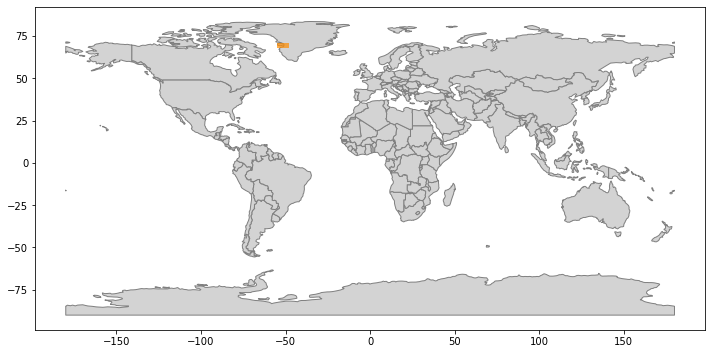

In [16]:
region_a.visualize_spatial_extent()

### Test the IS2 Class with polygon inputs

In [26]:
region_ap = ipd.Icesat2Data('ATL06',[(-64, 66), (-64, 72), (-55, 72), (-55, 66), (-64, 66)],\
                           ['2019-02-22','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59', version='2')

/home/jovyan/icepyx/icepyx/core/is2class.py:155: UserWarning: this type of input is not yet well handled and you may not be able to find data
  #user-entered polygon as a single list of lon and lat coordinates


In [22]:
region_ap.spatial_extent

['polygon',
 [[-64.0, -64.0, -55.0, -55.0, -64.0], [66.0, 72.0, 72.0, 66.0, 66.0]]]

In [43]:
region_ap.geodataframe()

,geometry
0,"POLYGON ((-64 66, -64 72, -55 72, -64 72, -64 ..."


In [20]:
%matplotlib inline

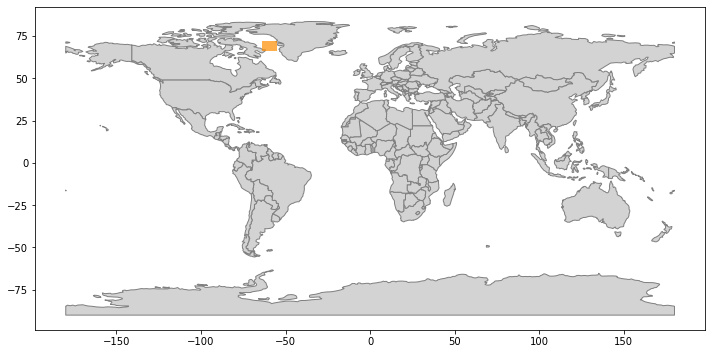

In [23]:
region_ap.visualize_spatial_extent()

In [25]:
region_ap.avail_granules()

{'errors': ['The polygon boundary contains both the North and South Poles. A polygon can contain at most one pole. Please check the order of your points.\n You may have provided them in the wrong order (clockwise vs counter-clockwise)']}


KeyError: 'feed'

In [20]:
region_p = ipd.Icesat2Data('ATL06','/home/jovyan/icepyx/doc/examples/supporting_files/data-access_PineIsland/glims_polygons.kml',\
                           ['2019-02-22','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59', version='2')

In [16]:
region_p.spatial_extent

['polygon',
 [[-86.622742,
   -86.561712,
   -86.868859,
   -86.962905,
   -89.02594,
   -89.630517,
   -89.830808,
   -90.746478,
   -91.668214,
   -92.049815,
   -93.420791,
   -93.997163,
   -94.277701,
   -95.133017,
   -96.513501,
   -99.889802,
   -100.114438,
   -100.355131,
   -100.462734,
   -100.827076,
   -101.795349,
   -102.424826,
   -101.188725,
   -101.564382,
   -103.37484,
   -103.914847,
   -104.012128,
   -103.029452,
   -102.350567,
   -101.837882,
   -101.899461,
   -101.280944,
   -101.325735,
   -101.190803,
   -101.250474,
   -101.175067,
   -101.402436,
   -101.326063,
   -101.449791,
   -101.310795,
   -101.357407,
   -101.217404,
   -101.295133,
   -101.058051,
   -100.447336,
   -98.433698,
   -97.28308,
   -97.491148,
   -96.514174,
   -96.552494,
   -96.384656,
   -96.441516,
   -97.139363,
   -97.193451,
   -97.64271,
   -96.297869,
   -96.327803,
   -95.721466,
   -95.748962,
   -94.940425,
   -94.988611,
   -94.911669,
   -95.609268,
   -95.637038,
   

In [17]:
region_p.geodataframe()

,geometry
0,"POLYGON ((-86.622742 -74.908126, -86.561712 -7..."


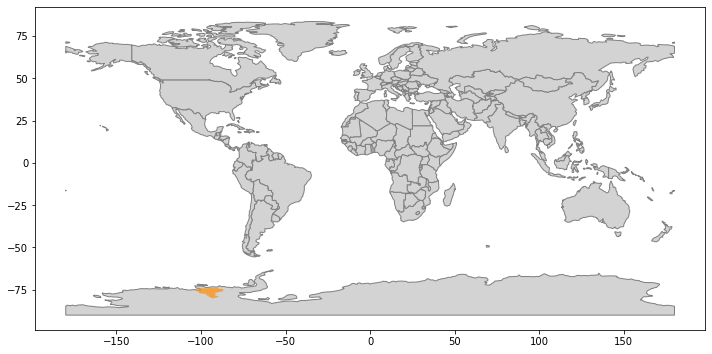

In [18]:
%matplotlib inline
region_p.visualize_spatial_extent()

In [5]:
region_p.avail_granules()

NameError: name 'region_p' is not defined

In [8]:
region_p2 = ipd.Icesat2Data('ATL06','/Users/jessica/Scripts/github/icesat2py/icepyx/doc/examples/supporting_files/data-access_PineIsland/glims_polygons.shp',\
                           ['2019-02-22','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59', version='2')

In [144]:
region_p2.spatial_extent

['polygon',
 [-86.622742,
  -74.908126,
  -86.561712,
  -74.870913,
  -86.868859,
  -74.730522,
  -86.962905,
  -74.605038,
  -89.02594,
  -74.316754,
  -89.630517,
  -74.192147,
  -89.830808,
  -74.065919,
  -90.746478,
  -73.956258,
  -91.668214,
  -74.023169,
  -92.049815,
  -73.929387,
  -93.420791,
  -73.929327,
  -93.997163,
  -73.882768,
  -94.277701,
  -73.714183,
  -95.133017,
  -73.966355,
  -96.513501,
  -74.127404,
  -99.889802,
  -74.085347,
  -100.114438,
  -74.019422,
  -100.355131,
  -74.080906,
  -100.462734,
  -74.240864,
  -100.827076,
  -74.373988,
  -101.795349,
  -74.369597,
  -102.424826,
  -74.497263,
  -101.188725,
  -74.7179,
  -101.564382,
  -75.02971,
  -103.37484,
  -75.273725,
  -103.914847,
  -75.426057,
  -104.012128,
  -75.5223,
  -103.029452,
  -75.748774,
  -102.350567,
  -75.749245,
  -101.837882,
  -75.943066,
  -101.899461,
  -76.014086,
  -101.280944,
  -76.192769,
  -101.325735,
  -76.246168,
  -101.190803,
  -76.27106,
  -101.250474,
  -76.34229

In [9]:
region_p2.geodataframe

<bound method Icesat2Data.geodataframe of <icepyx.core.is2class.Icesat2Data object at 0x11a006da0>>

In [38]:
%matplotlib notebook
region_p2.visualize_spatial_extent

<bound method Icesat2Data.visualize_spatial_extent of <icepyx.core.is2class.Icesat2Data object at 0x11a006da0>>

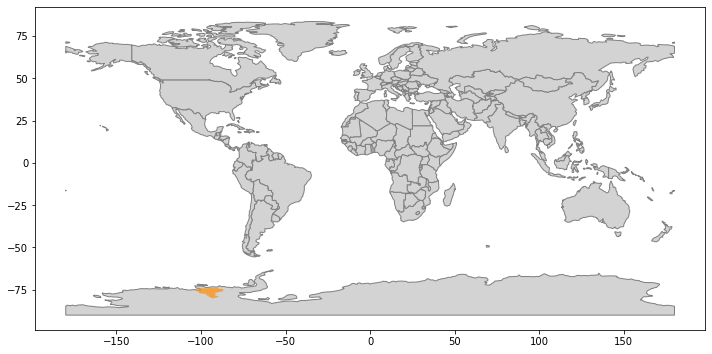

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
f, ax = plt.subplots(1, figsize=(12, 6))
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
region_p2.geodataframe().plot(ax=ax, color='#FF8C00',alpha = '0.7')
plt.show()

In [13]:
region_p.CMRparams

NameError: name 'region_p' is not defined

In [33]:
region_a.avail_granules()

{'Number of available granules': 12,
 'Average size of granules (MB)': 48.97541975975,
 'Total size of all granules (MB)': 587.7050371170001}

In [38]:
region_a.order_granules()

[]
order ID:  5000000534561
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete


In [53]:
region_a.download_granules(path)

Beginning download of zipped output...
Data request 5000000534561 of  1  order(s) is complete.


In [40]:
!pwd

/home/jovyan/icepyx


In [41]:
path='/home/jovyan/icepyx/dev-notebooks/fakedir'

In [31]:
session=region_a.earthdata_login('icepyx_devteam','jessica.scheick@maine.edu')

Earthdata Login password:  ·········


In [32]:
type(session)

requests.sessions.Session

In [9]:
exp = requests.sessions.Session
print(type(exp))

<class 'type'>


In [7]:
region_a.show_custom_options(session)

['ds_surf_type', 'ancillary_data/atlas_sdp_gps_epoch', 'ancillary_data/control', 'ancillary_data/data_end_utc', 'ancillary_data/data_start_utc', 'ancillary_data/end_cycle', 'ancillary_data/end_delta_time', 'ancillary_data/end_geoseg', 'ancillary_data/end_gpssow', 'ancillary_data/end_gpsweek', 'ancillary_data/end_orbit', 'ancillary_data/end_region', 'ancillary_data/end_rgt', 'ancillary_data/granule_end_utc', 'ancillary_data/granule_start_utc', 'ancillary_data/qa_at_interval', 'ancillary_data/release', 'ancillary_data/start_cycle', 'ancillary_data/start_delta_time', 'ancillary_data/start_geoseg', 'ancillary_data/start_gpssow', 'ancillary_data/start_gpsweek', 'ancillary_data/start_orbit', 'ancillary_data/start_region', 'ancillary_data/start_rgt', 'ancillary_data/version', 'ancillary_data/atmosphere/aclr_use_atlas', 'ancillary_data/atmosphere/alpha', 'ancillary_data/atmosphere/a_m1', 'ancillary_data/atmosphere/a_m2', 'ancillary_data/atmosphere/asr_cal_factor', 'ancillary_data/atmosphere/at

In [14]:
region_a.build_wanted_var_list()

max needed: 2
['ancillary_data' 'orbit_info' 'profile_1' 'profile_2' 'profile_3'
 'quality_assessment']
['atmosphere' 'bckgrd_atlas' 'high_rate' 'low_rate' 'none' 'profile_1'
 'profile_2' 'profile_3']


{'delta_time': ['profile_1/bckgrd_atlas/delta_time',
  'profile_1/high_rate/delta_time',
  'profile_1/low_rate/delta_time',
  'profile_2/bckgrd_atlas/delta_time',
  'profile_2/high_rate/delta_time',
  'profile_2/low_rate/delta_time',
  'profile_3/bckgrd_atlas/delta_time',
  'profile_3/high_rate/delta_time',
  'profile_3/low_rate/delta_time',
  'quality_assessment/profile_1/delta_time',
  'quality_assessment/profile_2/delta_time',
  'quality_assessment/profile_3/delta_time'],
 'latitude': ['profile_1/high_rate/latitude',
  'profile_1/low_rate/latitude',
  'profile_2/high_rate/latitude',
  'profile_2/low_rate/latitude',
  'profile_3/high_rate/latitude',
  'profile_3/low_rate/latitude'],
 'longitude': ['profile_1/high_rate/longitude',
  'profile_1/low_rate/longitude',
  'profile_2/high_rate/longitude',
  'profile_2/low_rate/longitude',
  'profile_3/high_rate/longitude',
  'profile_3/low_rate/longitude'],
 'bsnow_h': ['profile_1/high_rate/bsnow_h',
  'profile_1/low_rate/bsnow_h',
  'profil

In [15]:
region_a.variables

AttributeError('You must order or bring in a set of data files to populate this parameter')

In [22]:
vgrp = region_a.build_dataset_vardict('fake_fn.hdf5')

Loading variable lists from  file: /home/jovyan/icepyx/vardata/ATL09.json


In [24]:
region_a.build_subset_params(Coverage=region_a.build_wanted_var_list())

max needed: 2
['ancillary_data' 'orbit_info' 'profile_1' 'profile_2' 'profile_3'
 'quality_assessment']
['atmosphere' 'bckgrd_atlas' 'high_rate' 'low_rate' 'none' 'profile_1'
 'profile_2' 'profile_3']


In [25]:
region_a.subsetparams

{'time': '2019-02-20T00:00:00,2019-02-20T23:59:59',
 'bbox': '-55,68,-48,71',
 'Coverage': '/profile_1/bckgrd_atlas/delta_time,/profile_1/high_rate/delta_time,/profile_1/low_rate/delta_time,/profile_2/bckgrd_atlas/delta_time,/profile_2/high_rate/delta_time,/profile_2/low_rate/delta_time,/profile_3/bckgrd_atlas/delta_time,/profile_3/high_rate/delta_time,/profile_3/low_rate/delta_time,/quality_assessment/profile_1/delta_time,/quality_assessment/profile_2/delta_time,/quality_assessment/profile_3/delta_time,/profile_1/high_rate/latitude,/profile_1/low_rate/latitude,/profile_2/high_rate/latitude,/profile_2/low_rate/latitude,/profile_3/high_rate/latitude,/profile_3/low_rate/latitude,/profile_1/high_rate/longitude,/profile_1/low_rate/longitude,/profile_2/high_rate/longitude,/profile_2/low_rate/longitude,/profile_3/high_rate/longitude,/profile_3/low_rate/longitude,/profile_1/high_rate/bsnow_h,/profile_1/low_rate/bsnow_h,/profile_2/high_rate/bsnow_h,/profile_2/low_rate/bsnow_h,/profile_3/high_r

In [27]:
vdict=region_a.build_subset_vardict(vgrp)
print(vdict)


{'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'], 'a_m1': ['ancillary_data/atmosphere/a_m1'], 'a_m2': ['ancillary_data/atmosphere/a_m2'], 'aclr_use_atlas': ['ancillary_data/atmosphere/aclr_use_atlas'], 'alpha': ['ancillary_data/atmosphere/alpha'], 'asr_cal_factor': ['ancillary_data/atmosphere/asr_cal_factor'], 'atlas_bandpass_fw': ['ancillary_data/atmosphere/atlas_bandpass_fw'], 'atlas_tele_fov': ['ancillary_data/atmosphere/atlas_tele_fov'], 'backg_max_solar_elev': ['ancillary_data/atmosphere/backg_max_solar_elev'], 'backg_min_solar_elev': ['ancillary_data/atmosphere/backg_min_solar_elev'], 'backg_select': ['ancillary_data/atmosphere/backg_select'], 'bs_extinc_backs': ['ancillary_data/atmosphere/bs_extinc_backs'], 'bs_lay_max_size': ['ancillary_data/atmosphere/bs_lay_max_size'], 'bs_thresh_scale': ['ancillary_data/atmosphere/bs_thresh_scale'], 'bs_top_scale': ['ancillary_data/atmosphere/bs_top_scale'], 'bs_wind_thres': ['ancillary_data/atmosphere/bs_wind_thres'], 'cal_bot

In [34]:
print(len(variable_vals)-20)
print(len(vgrp))
print(len(vdict))

470
208
134


In [36]:
total=0
for key in vgrp.keys():
    total = total + len(vgrp[key])
print(total)

470


In [37]:
total2=0
for key in vdict.keys():
    total2 = total2 + len(vdict[key])
print(total2)

234


In [ ]:
region_a._cust_options.keys()

dict_keys(['options', 'fileformats', 'formatreproj', 'reprojectionONLY', 'noproj', 'variables'])

In [42]:
session=region_a.earthdata_login('jessica.scheick','jessica.scheick@maine.edu')

['Invalid username or password, please retry.']


TypeError: __init__() should return None, not 'Session'

In [39]:
region_a

In [55]:
region_a.build_CMR_params()

In [11]:
region_a.CMRparams

{'short_name': 'ATL06',
 'version': '002',
 'temporal': '2019-02-22T00:00:00Z,2019-02-28T23:59:59Z',
 'bounding_box': '-55,68,-48,71'}

In [24]:
obs_keys = region_a.CMRparams.keys()

In [20]:
region_a.build_reqconfig_params('download')

In [21]:
region_a.reqparams.keys()

dict_keys(['page_size', 'page_num', 'request_mode', 'include_meta'])

In [7]:
region_a.build_subset_params()

In [8]:
region_a.subsetparams

{'time': '2019-02-20T00:00:00,2019-02-28T23:59:59', 'bbox': '-55,68,-48,71'}

In [20]:
region_a.avail_granules()

AssertionError: Your search returned no results; try different search parameters

In [12]:
region_a.granules

[{'producer_granule_id': 'ATL06_20190221121851_08410203_002_01.h5',
  'time_start': '2019-02-21T12:19:05.000Z',
  'orbit': {'ascending_crossing': '-40.35812957405553',
   'start_lat': '59.5',
   'start_direction': 'A',
   'end_lat': '80',
   'end_direction': 'A'},
  'updated': '2019-10-24T13:18:53.725Z',
  'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-02-21T12:03:18.922Z',
    'equator_crossing_longitude': '-40.35812957405553',
    'orbit_number': '2429'}],
  'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V002',
  'data_center': 'NSIDC_ECS',
  'title': 'SC:ATL06.002:166292103',
  'coordinate_system': 'ORBIT',
  'time_end': '2019-02-21T12:24:16.000Z',
  'id': 'G1706343959-NSIDC_ECS',
  'original_format': 'ISO-SMAP',
  'granule_size': '56.0322761536',
  'browse_flag': True,
  'polygons': [['60.188087866839815 -48.12471565111877 79.13565976324539 -56.91308349854652 79.82054625244331 -57.75066986682175 79.88471463831527 -55.94835931630358 79.19580392788636 -5

In [36]:
region_a.order_granules(session, subset=False)

{'feed': {'updated': '2020-03-19T14:13:45.869Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/granules.json?short_name=ATL06&version=002&temporal=2019-02-20T00%3A00%3A00Z%2C2019-02-28T23%3A59%3A59Z&bounding_box=-55%2C68%2C-48%2C71&page_size=10&page_num=1', 'title': 'ECHO granule metadata', 'entry': [{'producer_granule_id': 'ATL06_20190221121851_08410203_002_01.h5', 'time_start': '2019-02-21T12:19:05.000Z', 'orbit': {'ascending_crossing': '-40.35812957405553', 'start_lat': '59.5', 'start_direction': 'A', 'end_lat': '80', 'end_direction': 'A'}, 'updated': '2019-10-24T13:18:53.725Z', 'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-02-21T12:03:18.922Z', 'equator_crossing_longitude': '-40.35812957405553', 'orbit_number': '2429'}], 'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V002', 'data_center': 'NSIDC_ECS', 'title': 'SC:ATL06.002:166292103', 'coordinate_system': 'ORBIT', 'time_end': '2019-02-21T12:24:16.000Z', 'id': 'G1706343959-NSIDC_ECS', 'original_for

In [19]:
region_a.order_granules(session, verbose=True)

{'feed': {'updated': '2020-03-19T14:36:44.733Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/granules.json?short_name=ATL06&version=002&temporal=2019-02-20T00%3A00%3A00Z%2C2019-02-28T23%3A59%3A59Z&bounding_box=-55%2C68%2C-48%2C71&page_size=10&page_num=1', 'title': 'ECHO granule metadata', 'entry': [{'producer_granule_id': 'ATL06_20190221121851_08410203_002_01.h5', 'time_start': '2019-02-21T12:19:05.000Z', 'orbit': {'ascending_crossing': '-40.35812957405553', 'start_lat': '59.5', 'start_direction': 'A', 'end_lat': '80', 'end_direction': 'A'}, 'updated': '2019-10-24T13:18:53.725Z', 'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-02-21T12:03:18.922Z', 'equator_crossing_longitude': '-40.35812957405553', 'orbit_number': '2429'}], 'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V002', 'data_center': 'NSIDC_ECS', 'title': 'SC:ATL06.002:166292103', 'coordinate_system': 'ORBIT', 'time_end': '2019-02-21T12:24:16.000Z', 'id': 'G1706343959-NSIDC_ECS', 'original_for

In [11]:
region_a.orderIDs

['5000000500408']

In [10]:
path = './downloadsubtest'
region_a.download_granules(session, path)

Beginning download of zipped output...
Data request 5000000500408 of  1  order(s) is complete.


In [80]:
region_a.download_granules(session,'/Users/jessica/Scripts/github/icesat2py/icepyx/download/')

order ID:  5000000420008
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete
Beginning download of zipped output...


KeyboardInterrupt: 

In [88]:
region_a.download_granules(session,'/Users/jessica/Scripts/github/icesat2py/icepyx/download/', verbose=True)

Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=002&temporal=2019-02-22T00%3A00%3A00Z%2C2019-02-28T23%3A59%3A59Z&bounding_box=-64%2C66%2C-55%2C72&page_size=10&page_num=1&request_mode=async&agent=NO&include_meta=Y
Order request response XML content:  b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/esi/rsp/i" xmlns:ssw="http://newsroom.gsfc.nasa.gov/esi/rsp/ssw" xmlns:eesi="http://eosdis.nasa.gov/esi/rsp/e" xmlns:esi="http://eosdis.nasa.gov/esi/rsp" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n    <order>\n        <orderId>5000000420018</orderId>\n        <Instructions>You may receive an email about your order if you specified an EMAIL address. &lt;br/&gt;&lt;br/&gt;The instructions used to process 

ValueError: Please confirm that you have submitted a valid order and it has successfully completed.

## Steps required by the user
- create icesat2data object with the minimum inputs (dataset, time period, spatial extent)
- enter Earthdata login credentials and open an active session
- download data (querying can be done prior to logging in)

## Info supplied by the user
- dataset of interest, also known as "short name".
See https://nsidc.org/data/icesat-2/data-sets for a list of the available datasets.
- Time period of interest (start date and time, end date and time)
- spatial area of interest (now only as a bounding box)

- earthdata login and password
- valid email address

## Elements to develop further (or include in an example, as in Amy's tutorial)
- polygon visualization
- input of polygon (including simplification steps) instead of bounding box

## Info from the user - any subsetting and reformatting requests
#### These reformatting options are optional

The NSIDC DAAC supports customization services on many of our NASA Earthdata mission collections. Reformatting and subsetting are available on all Level-2 and -3 ICESat-2 data sets. Let's discover the specific service options supported for this data set and select which of these services we want to request. 

We will start by querying the service capability to gather and select customization options.

In [1]:
# Query service capability URL 

from xml.etree import ElementTree as ET

short_name = 'ATL06'
latest_version = '002'

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

print(capability_url)

https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL06.002.xml


In [23]:
# Create session to store cookie and pass credentials to capabilities url
session = requests.session()

In [51]:
print(session.auth)

None


In [47]:
s = session.get(capability_url)

In [49]:
root = ET.fromstring(response.content)

In [50]:
print(response)

<Response [200]>


All of NSIDC's service endpoints are behind NASA Earthdata Login. We need to create a session to store cookies and pass Earthdata Login credentials to capabilities url.

From the service capability XML, we can collect lists with each service option to gather service information.

In [2]:
# collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]

NameError: name 'root' is not defined

#### Let's confirm that subset services exist for our data set by reviewing the `subagent` list. If the list contains service information, we know that services are available. If not, we need to set the `agent` API parameter to `NO` to indicate that our request will bypass the subsetter. This will quickly send back the data "natively" without any customization applied.

In [27]:
print(subagent)
if len(subagent) < 1 :
    agent = 'NO'

[{'id': 'ICESAT2', 'spatialSubsetting': 'true', 'spatialSubsettingShapefile': 'true', 'temporalSubsetting': 'true', 'type': 'both', 'maxGransSyncRequest': '100', 'maxGransAsyncRequest': '2000'}]


More information is contained in the subagent list, including the maximum number of granules that we can request per order depending on our configuration. We'll come back to these options below.

### We'll begin populating the subsetting and reformatting parameters used for our NSIDC API request. In addition to the CMR information we queried above, the NSIDC API accepts Key-Value-Pairs (KVPs) for subsetting and reformatting services.

#### Let's start with spatial subsetting. Recall that there are three options to *filter* our search results by spatial constraint: 

1) Bounding Box: Corresponding to the CMR `bounding_box` KVP

2) Polygon coordinate pairs: Corresponding to the CMR `polygon` KVP

3) Spatial file input, including Esri Shapefile or KML/KMZ: We simplified the file input to also be read by the CMR `polygon` KVP 
    
#### We see above that `spatialSubsetting` is `true` and `spatialSubsettingShapefile` is `true`. Therefore the same *filtering* options can be applied to our *subset* constraint, with unique KVPs for the subsetting service:

1) Bounding Box: `bbox` subset KVP

2) Polygon coordinate pairs: `bounding_shape` subset KVP in [GeoJSON](https://geojson.org/) format. 

3) Spatial file input: The file can be read directly by the subsetter without simplification. This file will be posted to the API endpoint, so we don't need to specify an additional subset KVP here. 

#### Because we're pursuing option 3), we don't need to provide an additional subset parameter. Below is commented code for bounding box inputs.

#### Temporal subsetting is next, since we saw above that `temporalSubsetting` is `true`. We filtered data over 22 Feb 2019 and we can also subset the data to those dates if desired. 

The `time` KVP is used to subset temporally. This can be entered in the following formats:

`time=yyyy-mm-dd,yyyy-mm-dd`

`time=yyy-mm-ddThh:MM:ss,yyy-mm-ddThh:MM:ss` 

In [ ]:
# Temporal subsetting KVP

timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time
print(timevar)

#### Next, let's explore the reformatting options available.


In [ ]:
print(format_vals)

These options can be inputted into the API request exactly as printed in the list, with quotes removed, using the `format=` Key-Value-Pair. For example:

`format=TABULAR_ASCII`

We will be exploring the data in its native HDF5 format so we won't pursue this option in this tutorial. 

#### Reprojection options will be available on the gridded ICESat-2 L3B data sets. Let's confirm that no reprojection options exist:

In [ ]:
print(proj_vals)

#### Finally, let's determine if variable subsetting is available by finding the length of the `variable_vals` list we gathered from the capabilities URL. 

In [ ]:
len(variable_vals)

We can view the entire list of variables if desired:

In [ ]:
pprint.pprint(variable_vals)

And we can enter a list of variables to subset separated by comma using the `coverage` key. All forward slashes need to be included to indicate HDF group hierarchy.

In [ ]:
coverage = '/ancillary_data/atlas_sdp_gps_epoch,\
/gt1l/land_ice_segments/atl06_quality_summary,\
/gt1l/land_ice_segments/delta_time,\
/gt1l/land_ice_segments/h_li,\
/gt1l/land_ice_segments/h_li_sigma,\
/gt1l/land_ice_segments/latitude,\
/gt1l/land_ice_segments/longitude,\
/gt1l/land_ice_segments/segment_id,\
/gt1l/land_ice_segments/sigma_geo_h,\
/gt1r/land_ice_segments/atl06_quality_summary,\
/gt1r/land_ice_segments/delta_time,\
/gt1r/land_ice_segments/h_li,\
/gt1r/land_ice_segments/h_li_sigma,\
/gt1r/land_ice_segments/latitude,\
/gt1r/land_ice_segments/longitude,\
/gt1r/land_ice_segments/segment_id,\
/gt1r/land_ice_segments/sigma_geo_h,\
/gt2l/land_ice_segments/atl06_quality_summary,\
/gt2l/land_ice_segments/delta_time,\
/gt2l/land_ice_segments/h_li,\
/gt2l/land_ice_segments/h_li_sigma,\
/gt2l/land_ice_segments/latitude,\
/gt2l/land_ice_segments/longitude,\
/gt2l/land_ice_segments/segment_id,\
/gt2l/land_ice_segments/sigma_geo_h,\
/gt2r/land_ice_segments/atl06_quality_summary,\
/gt2r/land_ice_segments/delta_time,\
/gt2r/land_ice_segments/h_li,\
/gt2r/land_ice_segments/h_li_sigma,\
/gt2r/land_ice_segments/latitude,\
/gt2r/land_ice_segments/longitude,\
/gt2r/land_ice_segments/segment_id,\
/gt2r/land_ice_segments/sigma_geo_h,\
/gt3l/land_ice_segments/atl06_quality_summary,\
/gt3l/land_ice_segments/delta_time,\
/gt3l/land_ice_segments/h_li,\
/gt3l/land_ice_segments/h_li_sigma,\
/gt3l/land_ice_segments/latitude,\
/gt3l/land_ice_segments/longitude,\
/gt3l/land_ice_segments/segment_id,\
/gt3l/land_ice_segments/sigma_geo_h,\
/gt3r/land_ice_segments/atl06_quality_summary,\
/gt3r/land_ice_segments/delta_time,\
/gt3r/land_ice_segments/h_li,\
/gt3r/land_ice_segments/h_li_sigma,\
/gt3r/land_ice_segments/latitude,\
/gt3r/land_ice_segments/longitude,\
/gt3r/land_ice_segments/segment_id,\
/gt3r/land_ice_segments/sigma_geo_h,\
/orbit_info/cycle_number,\
/orbit_info/rgt,\
/orbit_info/orbit_number' 

## Submitting the request - behind the scenes

### Submit the search query

#### We will now populate dictionaries to be applied to our search query below based on spatial and temporal inputs. For additional search parameters, see the [The Common Metadata Repository API documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation").


In [6]:
#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

if aoi == '1':
# bounding box input:
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

print('CMR search parameters: ', params)

NameError: name 'aoi' is not defined

#### Input the parameter dictionary to the CMR granule search to query all granules that meet the criteria based on the granule metadata. Print the number of granules returned.

In [ ]:
# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

    
# Get number of granules over my area and time of interest
len(granules)


In [26]:
granules = region_a.granules
len(granules)

6

#### Although subsetting, reformatting, or reprojecting can alter the size of the granules, this "native" granule size can still be used to guide us towards the best download method to pursue, which we will come back to later on in this tutorial.

## Request data from the NSIDC data access API.

#### We will now set up our data download request. The data access and service API (labeled EGI below) incorporates the CMR parameters that we explored above, plus customization service parameters as well as a few configuration parameters.

![Data Access Service API diagram](https://gsfc-ngap-developer.s3.amazonaws.com/be03ae4ddbe19c8ea7734df6941385b8baba4741f6c7ec62fd4230eccdc31fc0)

#### As described above, the API is structured as a URL with a base plus individual key-value-pairs (KVPs) separated by ‘&’. The base URL of the NSIDC API is: </br>
`https://n5eil02u.ecs.nsidc.org/egi/request`


In [ ]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#### Let's go over the configuration parameters:

* `request_mode`
* `page_size`
* `page_num`

`request_mode` is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed" to your working directory. For this tutorial, we will set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

**Use the streaming `request_mode` with caution: While it can be beneficial to stream outputs directly to your local directory, note that timeout errors can result depending on the size of the request, and your request will not be queued in the system if NSIDC is experiencing high request volume. For best performance, I recommend setting `page_size=1` to download individual outputs, which will eliminate extra time needed to zip outputs and will ensure faster processing times per request. An example streaming request loop is available at the bottom of the tutorial below. **

Recall that we queried the total number and volume of granules prior to applying customization services. `page_size` and `page_num` can be used to adjust the number of granules per request up to a limit of 2000 granules for asynchronous, and 100 granules for synchronous (streaming). For now, let's select 10 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. 

In [ ]:
# Set number of granules requested per order, which we will initially set to 10.
page_size = 10

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)

#Set request mode. 
request_mode = 'async'

# Determine how many individual orders we will request based on the number of granules requested

print(page_num)

#### After all of these KVP inputs, what does our request look like? Here's a summary of all possible KVPs that we explored, both for CMR searching and for the subsetter:

#### CMR search keys:
* `short_name=`
* `version=`
* `temporal=`
* `bounding_box=`
* `polygon=`

#### Customization service keys:
* `time=`
* `bbox=`
* `bounding_shape=` 
* `format=`
* `projection=`
* `projection_parameters=`
* `Coverage=`

#### No customization (access only):
* `agent=`    
* `include_meta=` 
    * `Y` by default. `N` for No metadata requested.

#### Request configuration keys:
* `request_mode=` 
* `page_size=`
* `page_num=`
* `token=`
* `email=`

#### If we were to create an API request based on our request parameters and submit into a web browser for example, here's what we end up with:

In [ ]:
#Print API base URL + request parameters --> for polygon
API_request = f'{base_url}?short_name={short_name}&version={latest_version}&temporal={temporal}&time={timevar}&polygon={polygon}&Coverage={coverage}&request_mode={request_mode}&page_size={page_size}&page_num={page_num}&token={token}&email={email}'
print(API_request)


In [ ]:
#Print API base URL + request parameters --> for bbox
API_request = f'{base_url}?short_name={short_name}&version={latest_version}&temporal={temporal}&time={timevar}\
&bbox={bbox}&Coverage={coverage}&request_mode={request_mode}&page_size={page_size}&page_num={page_num}&token={token}&email={email}'
print(API_request)


#### We'll also create a new dictionary of NSIDC API KVPs to be used in our subset request. Because we are looping through each page of requests, we'll add the `page_num` KVP to our dictionary within the loop below.

In [ ]:
subset_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'time': timevar, 
    'polygon': polygon, 
    'Coverage': coverage, 
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }
print(subset_params)

In [ ]:
subset_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'time': timevar, 
    'bbox': bbox, 
    'Coverage': coverage, 
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }
print(subset_params)

#### We'll request the same data but without any subsetting services applied. Let's create another request parameter dictionary with the `time` and `coverage` service keys removed, and we'll add `agent=NO` instead.

In [ ]:
request_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'bbox': bbox, #'polygon': polygon, 
    'agent' : 'NO',
    'include_meta' : 'Y',
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }

print(request_params)

## Request Data

#### Finally, we'll download the data directly to this notebook directory in a new Outputs folder. The progress of each order will be reported.

We'll start by creating an output folder if the folder does not already exist.

In [ ]:
path = str(os.getcwd() + '/Outputs')
if not os.path.exists(path):
    os.mkdir(path)

First we'll submit our request without subsetting services:

In [ ]:
# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    request_params.update( {'page_num': page_val} )
    
# For all requests other than spatial file upload, use get function
    request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

#Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

#Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

#Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

#Continue loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

#find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

#Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')


Let's run our request loop again, this time with subsetting services applied. We will post the KML file directly to the API:

In [ ]:
# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    subset_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file

#     shape_post = {'shapefile': open(kml_filepath, 'rb')}
#     request = session.post(base_url, params=subset_params, files=shape_post) 
    
# FOR ALL OTHER REQUESTS THAT DO NOT UTILIZED AN UPLOADED POLYGON FILE, USE A GET REQUEST INSTEAD OF POST:
    request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')


#### Why did we get an error? 

Errors can occur when our search filter overestimates the extent of the data contained within the granule. CMR uses orbit metadata to determine the extent of the file, including the following parameters:

Collection-level:
* `SwathWidth`
* `Period`
* `InclinationAngle`
* `NumberOfOrbits` 
* `StartCircularLatitude` 

Granule level: 
* `AscendingCrossing`
* `StartLatitude`
* `StartDirection`
* `EndLatitude`
* `EndDirection` 

However, the values themselves are not inspected during our search. This can be a relatively common error for ICESat-2 search and access because of the limitations of the metadata, but it only means that more data were returned in the search results as a "false positive" compared to what the subsetter found when cropping the data values. 

#### Clean up the Output folder by removing individual order folders:

In [ ]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

In [ ]:
#List files
sorted(os.listdir(path))

If you're interested in the streaming request method, an example loop is below: 

In [ ]:
# Set page size to 1 to improve performance
page_size = 1
request_params.update( {'page_size': page_size})

# No metadata to only return a single output
request_params.update( {'include_meta': 'N'})

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)
print(page_num)

#Set request mode. 
request_params.update( {'request_mode': 'stream'})

print(request_params)

os.chdir(path)

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    request_params.update( {'page_num': page_val})
    request = session.get(base_url, params=request_params)
    print('HTTP response from order response URL: ', request.status_code)
    request.raise_for_status()
    d = request.headers['content-disposition']
    fname = re.findall('filename=(.+)', d)
    open(eval(fname[0]), 'wb').write(request.content)
    print('Data request', page_val, 'is complete.')

### Before we request the data and download the outputs, let's explore some simple comparisons of the data from s3 that we've already requested.

In [ ]:
# Define paths for output folders

opath = '/home/jovyan/data-access/data-access-outputs'
sopath = '/home/jovyan/data-access/data-access-subsetted-outputs'

# Choose the same native/subsetted file to compare

native_file = opath + '/ATL06_20190222031203_08500210_001_01.h5'
processed_file = sopath + '/processed_ATL06_20190222031203_08500210_001_01.h5'

Compare file sizes:

In [ ]:
os.path.getsize(native_file)

In [ ]:
os.path.getsize(processed_file)

Read the files using h5py and compare the HDF5 groups and datasets:

In [ ]:
# Read files using h5py package

native = h5py.File(native_file, 'r')
processed = h5py.File(processed_file, 'r')


Native file groups:

In [ ]:
printGroups = True
groups = list(native.keys())
for g in groups:
    group = native[g]
    if printGroups:
        print('---')
        print('Group: {}'.format(g))
        print('---')
        for d in group.keys():
            print(group[d])

Subsetted file groups:

In [ ]:
printGroups = True
groups = list(processed.keys())
for g in groups:
    group = processed[g]
    if printGroups:
        print('---')
        print('Group: {}'.format(g))
        print('---')
        for d in group.keys():
            print(group[d])


Compare geolocation range from the /gt1l/land_ice_segments group:

In [ ]:
with h5py.File(native_file,'r') as native:
    native_groups = list(native.keys())
    n_hvar = native['/gt1l/land_ice_segments/h_li']
    n_h = n_hvar[:]
    n_latvar = native['/gt1l/land_ice_segments/latitude']
    n_latitude = n_latvar[:]
    n_lonvar = native['/gt1l/land_ice_segments/longitude']
    n_longitude = n_lonvar[:]

with h5py.File(processed_file,'r') as processed:
    processed_groups = list(processed.keys())
    p_hvar = processed['/gt1l/land_ice_segments/h_li']
    p_h = p_hvar[:]
    p_latvar = processed['/gt1l/land_ice_segments/latitude']
    p_latitude = p_latvar[:]
    p_lonvar = processed['/gt1l/land_ice_segments/longitude']
    p_longitude = p_lonvar[:]
    
print('array size of native file height variable:')
print(len(n_h))
print('array size of subsetted height variable:')
print(len(p_h))

print('native file latitude range:')
print(min(n_latitude), max(n_latitude))
print('native file longitude range:')
print(min(n_longitude), max(n_longitude))

print('subsetted file latitude range:')
print(min(p_latitude), max(p_latitude))
print('subsetted file longitude range:')
print(min(p_longitude), max(p_longitude))

In [1]:
a=[1,2,3,4]
len(a[0])

TypeError: object of type 'int' has no len()

In [3]:
a=[[0,1],[1,2],[2,3],[3,4]]
type(a)

list

In [4]:
len(a[0])

2

In [5]:
a[3][1]

4